In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from keras.models import Model
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
import keras.backend as K

from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [ ]:
# make the original data
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1

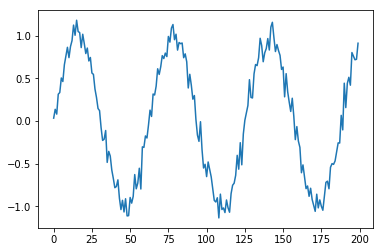

In [ ]:
# plot it
plt.plot(series)
plt.show()

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

In [ ]:
# split into train and test
Xtrain, Ytrain = X[:-N//2], Y[:-N//2]
Xtest, Ytest = X[-N//2:], Y[-N//2:]

In [ ]:
### try autoregressive model
model = LinearRegression()
model.fit(Xtrain, Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# get model predictions
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

In [ ]:
# print R^2
print("linear train r^2:", model.score(Xtrain, Ytrain))
print("linear test r^2:", model.score(Xtest, Ytest))

linear train r^2: 0.9758727402130734
linear test r^2: 0.9645383238706098


In [ ]:
# print MAE
print("linear train mae:", mae(Ytrain, Ptrain))
print("linear test mae:", mae(Ytest, Ptest))

linear train mae: 0.08666016760793387
linear test mae: 0.10576255112652039


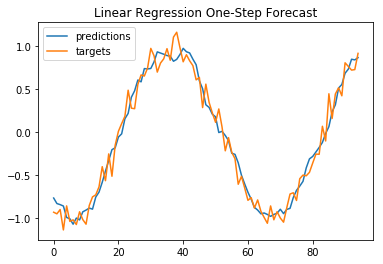

In [ ]:
# One-Step Forecast
plt.plot(Ptest, label='predictions')
plt.plot(Ytest, label='targets')
plt.title("Linear Regression One-Step Forecast")
plt.legend()
plt.show()

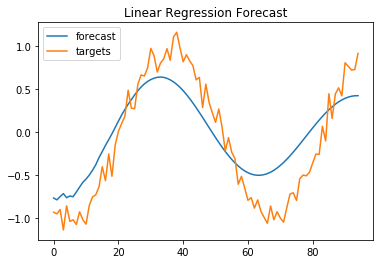

In [ ]:
# Real forecast
forecast = []
input_ = Xtest[0]
while len(forecast) < len(Ytest):
  x = np.expand_dims(input_, 0)
  f = model.predict(x)
  forecast.append(f[0])
  # make a new input with the latest forecast
  input_ = np.concatenate([input_[1:], f])

plt.plot(forecast, label='forecast')
plt.plot(Ytest, label='targets')
plt.title("Linear Regression Forecast")
plt.legend()
plt.show()

In [ ]:
# Make inputs N x T x D
inputs_train = Xtrain.reshape(-1, T, 1)
inputs_test = Xtest.reshape(-1, T, 1)

In [ ]:
# make the RNN
i = Input(shape=(T, D))
x = SimpleRNN(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

In [ ]:
# train the RNN
r = model.fit(
  inputs_train, Ytrain,
  batch_size=32,
  epochs=80,
  validation_data=(inputs_test, Ytest),
)

Train on 95 samples, validate on 95 samples
Epoch 1/80
95/95 [==============================] - 0s 4ms/step - loss: 0.8905 - val_loss: 0.4227
Epoch 2/80
95/95 [==============================] - 0s 701us/step - loss: 0.2457 - val_loss: 0.0721
Epoch 3/80
95/95 [==============================] - 0s 604us/step - loss: 0.0928 - val_loss: 0.1066
Epoch 4/80
95/95 [==============================] - 0s 640us/step - loss: 0.0818 - val_loss: 0.0355
Epoch 5/80
95/95 [==============================] - 0s 646us/step - loss: 0.0347 - val_loss: 0.0398
Epoch 6/80
95/95 [==============================] - 0s 618us/step - loss: 0.0313 - val_loss: 0.0405
Epoch 7/80
95/95 [==============================] - 0s 596us/step - loss: 0.0221 - val_loss: 0.0321
Epoch 8/80
95/95 [==============================] - 0s 629us/step - loss: 0.0215 - val_loss: 0.0295
Epoch 9/80
95/95 [==============================] - 0s 565us/step - loss: 0.0219 - val_loss: 0.0260
Epoch 10/80
95/95 [==============================] - 0s 62

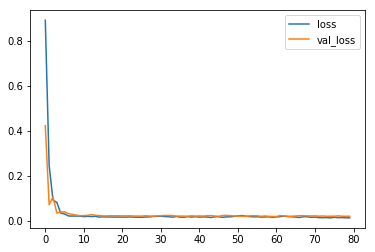

In [ ]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# Get flattened predictions
Ptrain = model.predict(inputs_train).flatten()
Ptest = model.predict(inputs_test).flatten()

In [ ]:
print("rnn train mae:", mae(Ytrain, Ptrain))
print("rnn test mae:", mae(Ytest, Ptest))

rnn train mae: 0.08606290469668032
rnn test mae: 0.11470198690376308


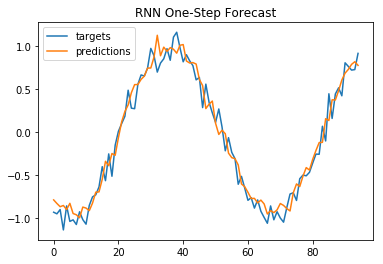

In [ ]:
# plot predictions vs targets
plt.plot(Ytest, label='targets')
plt.plot(Ptest, label='predictions')
plt.title("RNN One-Step Forecast")
plt.legend()
plt.show()

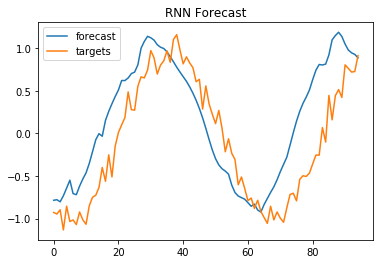

In [ ]:
# Real forecast
forecast = []
input_ = Xtest[0]
while len(forecast) < len(Ytest):
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(forecast, label='forecast')
plt.plot(Ytest, label='targets')
plt.title("RNN Forecast")
plt.legend()
plt.show()